<a href="https://colab.research.google.com/github/srv96/AI-ML-TensorFlow/blob/main/GAN_Advance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# map inputs to (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
print("x_train.shape:", x_train.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train.shape: (60000, 28, 28)


In [3]:
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [4]:
latent_dim = 100

In [5]:
# Get the generator model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(negative_slope=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(negative_slope=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(negative_slope=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [6]:
# Get the discriminator model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(negative_slope=0.2))(i)
  x = Dense(256, activation=LeakyReLU(negative_slope=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

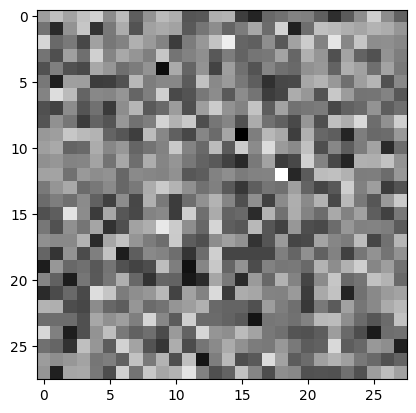

In [7]:
# Build the generator
generator = build_generator(latent_dim)

# Make an image!
noise = np.random.randn(1, latent_dim)
generated_image = generator(noise, training=False)
generated_image = generated_image.numpy()
generated_image = generated_image.reshape(H, W)
plt.imshow(generated_image, cmap='gray')

In [8]:
# Build the discriminator
discriminator = build_discriminator(D)

prob_real = discriminator(generated_image.reshape(1, D))
print(prob_real)

tf.Tensor([[0.4616088]], shape=(1, 1), dtype=float32)


In [9]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [10]:
def discriminator_loss(real_output, fake_output):
  # for discriminator, real target = 1, fake target = 0
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [11]:
def generator_loss(fake_output):
  # for generator, fake target = 1
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
# Both networks are trained separately so we need 2 optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)

In [13]:
# Train the GAN
# Config
batch_size = 32
epochs = 16
sample_period = 200 # every `sample_period` steps generate and save some data

# we'll re-use the seed noise when generating example fake images
rows, cols = 5, 5
seed_noise = tf.random.normal([rows * cols, latent_dim])

# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# Store the losses
d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [14]:
# A function to generate a grid of random samples from the generator
# and save them to a file
def sample_images(epoch):
  imgs = generator.predict(seed_noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [15]:
# Define a training step
# See "Advanced Tensorflow Usage" on GradientTape
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, latent_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    # compute discriminator accuracy
    real_acc = tf.reduce_mean(tf.cast(real_output > 0.5, tf.float32))
    fake_acc = tf.reduce_mean(tf.cast(fake_output < 0.5, tf.float32))
    disc_acc = (real_acc + fake_acc) / 2

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gen_grad = gen_tape.gradient(
      gen_loss, generator.trainable_variables)
  disc_grad = disc_tape.gradient(
      disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(
      zip(gen_grad, generator.trainable_variables))

  # does discriminator change when we update generator?
  real_output = discriminator(images, training=True)
  fake_output = discriminator(generated_images, training=True)

  # compute discriminator accuracy
  real_acc = tf.reduce_mean(tf.cast(real_output > 0.5, tf.float32))
  fake_acc = tf.reduce_mean(tf.cast(fake_output < 0.5, tf.float32))
  disc_acc2 = (real_acc + fake_acc) / 2

  discriminator_optimizer.apply_gradients(
      zip(disc_grad, discriminator.trainable_variables))
  # do it again!
  # generator_optimizer.apply_gradients(
  #     zip(gen_grad, generator.trainable_variables))
  return gen_loss, disc_loss, disc_acc, disc_acc2

In [16]:
train_ds = tf.data.Dataset.from_tensor_slices(
    x_train).shuffle(1000).batch(batch_size)

In [17]:
# Main training loop
i = 0
for epoch in range(epochs):
  for x_batch in train_ds:
    # Train both discriminator and generator
    g_loss, d_loss, d_acc, d_acc2 = train_step(x_batch)

    if d_acc != d_acc2:
      print("d_acc != d_acc2")

    # Save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if i % sample_period == 0:
      sample_images(i)

    i += 1

  # print loss at end of each epoch
  print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
    d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
epoch: 1/16, d_loss: 1.13,     d_acc: 0.73, g_loss: 0.93
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
epoch: 2/16, d_loss: 1.13,     d_acc: 0.72, g_loss: 1.29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

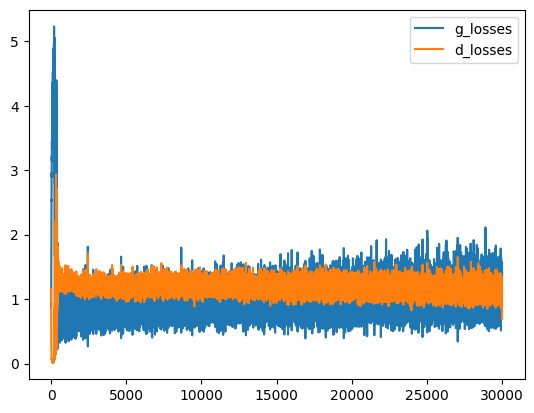

In [18]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [19]:
!ls gan_images

0.png	   12800.png  16000.png  19000.png  22000.png  25000.png  2800.png   4200.png  7400.png
10000.png  13000.png  1600.png	 19200.png  2200.png   25200.png  28200.png  4400.png  7600.png
1000.png   13200.png  16200.png  19400.png  22200.png  25400.png  28400.png  4600.png  7800.png
10200.png  13400.png  16400.png  19600.png  22400.png  25600.png  28600.png  4800.png  8000.png
10400.png  13600.png  16600.png  19800.png  22600.png  25800.png  28800.png  5000.png  800.png
10600.png  13800.png  16800.png  20000.png  22800.png  26000.png  29000.png  5200.png  8200.png
10800.png  14000.png  17000.png  2000.png   23000.png  2600.png   29200.png  5400.png  8400.png
11000.png  1400.png   17200.png  200.png    23200.png  26200.png  29400.png  5600.png  8600.png
11200.png  14200.png  17400.png  20200.png  23400.png  26400.png  29600.png  5800.png  8800.png
11400.png  14400.png  17600.png  20400.png  23600.png  26600.png  29800.png  6000.png  9000.png
11600.png  14600.png  17800.png  20600.png  

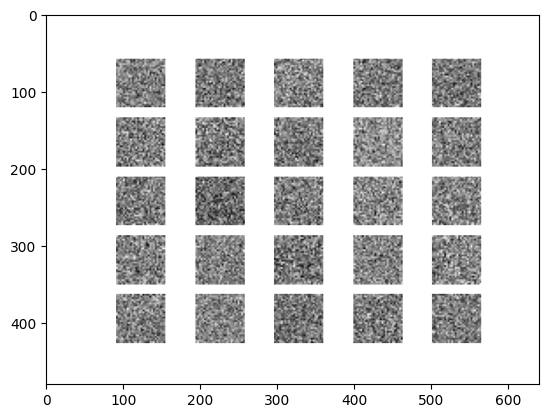

In [20]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

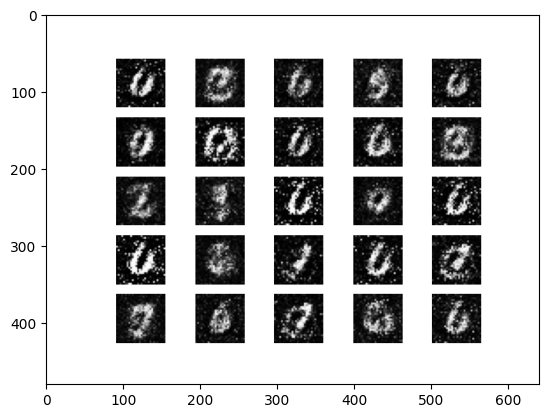

In [21]:
a = imread('gan_images/1000.png')
plt.imshow(a)

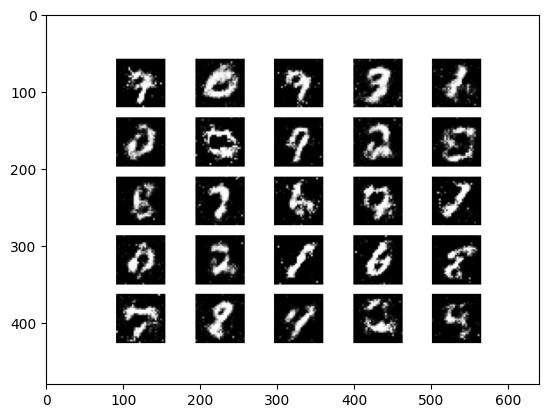

In [22]:
a = imread('gan_images/5000.png')
plt.imshow(a)

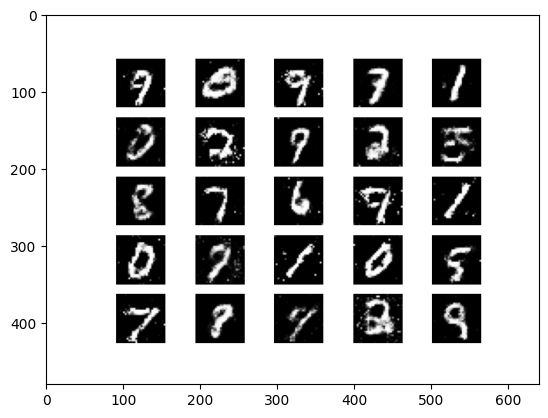

In [23]:
a = imread('gan_images/10000.png')
plt.imshow(a)

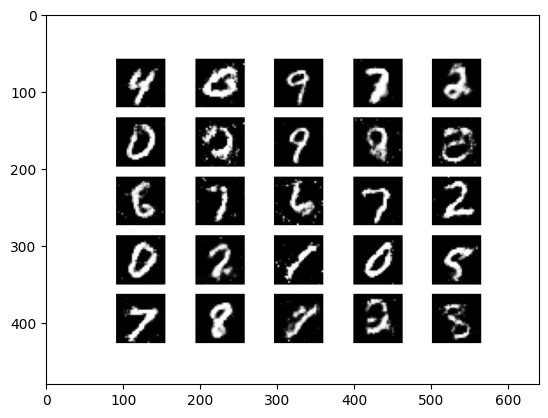

In [24]:
a = imread('gan_images/20000.png')
plt.imshow(a)

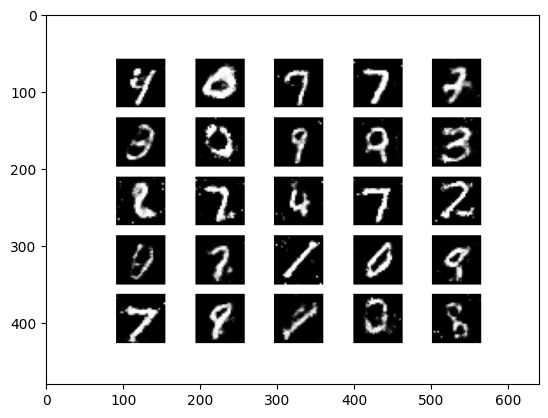

In [25]:
a = imread('gan_images/29800.png')
plt.imshow(a)